In [ ]:
import kagglehub

# download dataset from kaggle via kagglehub api
path = kagglehub.dataset_download("balraj98/massachusetts-roads-dataset")

print("Path to dataset files:", path)

c:\Users\TYC\Desktop\python code\satellite_road_seg\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 5.76G/5.76G [05:04<00:00, 20.3MB/s] 

Extracting files...


Path to dataset files: C:\Users\TYC\.cache\kagglehub\datasets\balraj98\massachusetts-roads-dataset\versions\1


In [59]:
import os
import matplotlib.pyplot as plt
import random
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm


In [60]:
#path
image_dir = "./MA_road_data/tiff/train2"
mask_dir = "./MA_road_data/tiff/train_labels2"

#make list of files
image_files = os.listdir(image_dir)
mask_files = os.listdir(mask_dir)

print(f"Number of images: {len(image_files)}")
print(f"Number of masks: {len(mask_files)}")

Number of images: 1157
Number of masks: 1157


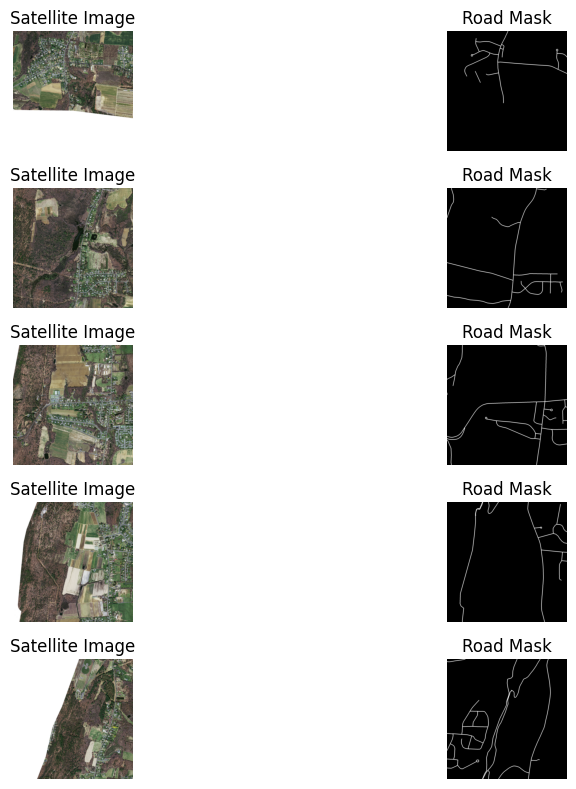

In [61]:
#pick first 5 images and masks to display

plt.figure(figsize=(12,8))
for i, idx in enumerate(range(5)):

    img_path = os.path.join(image_dir, image_files[idx])
    mask_path = os.path.join(mask_dir, mask_files[idx])

    image=Image.open(img_path)
    mask=Image.open(mask_path)

    #plot image
    plt.subplot(5, 2, i*2+1)
    plt.imshow(image)
    plt.title("Satellite Image")
    plt.axis('off')

    #plot mask
    plt.subplot(5, 2, i*2+2)
    plt.imshow(mask, cmap='gray')
    plt.title("Road Mask")  
    plt.axis('off')

plt.tight_layout()
plt.show()

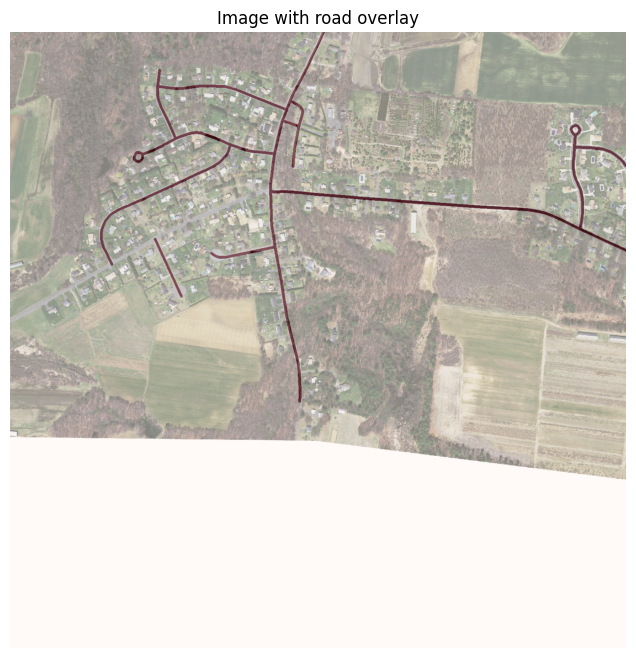

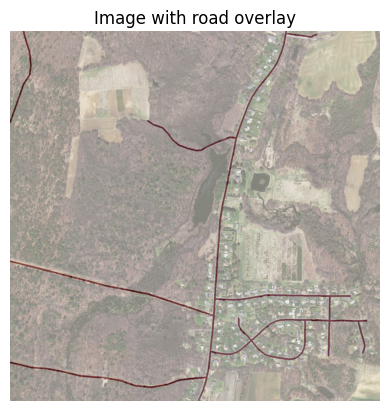

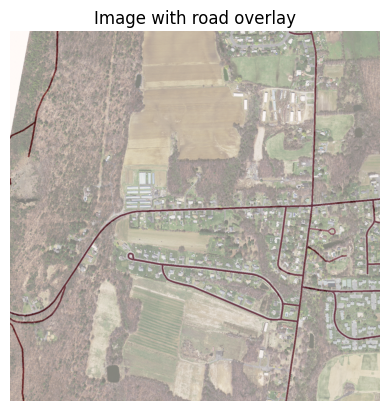

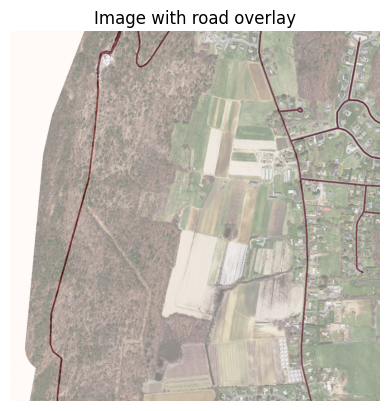

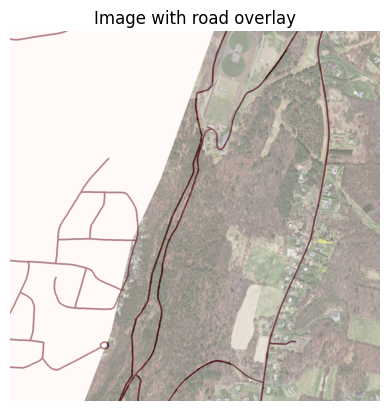

In [62]:
#overlay mask on image

plt.figure(figsize=(12,8))
for i, idx in enumerate(range(5)):

    img_path = os.path.join(image_dir, image_files[idx])
    mask_path = os.path.join(mask_dir, mask_files[idx])

    image=Image.open(img_path)
    mask=Image.open(mask_path)

    plt.imshow(image)
    plt.imshow(mask, cmap='Reds', alpha=0.5)
    plt.title("Image with road overlay")
    plt.axis('off')
    plt.show()  

In [63]:
#data augmentation for same transform on image and mask

class Augment:
    def __call__(self, image, mask):

        #random h flip
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        #random v flip
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)   

        #random rotation 90 degree
        if random.random() > 0.5:
            angle = random.choice([90, 180, 270])
            image = TF.rotate(image, angle)
            mask = TF.rotate(mask, angle)

        return image, mask

In [64]:
#declare a class for the dataset to be used in dataloader

class RoadDataset(Dataset):

    def __init__(self, image_dir, mask_dir, transform=None, augment=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_files = sorted(os.listdir(image_dir))
        self.mask_files = sorted(os.listdir(mask_dir))
        self.transform = transform
        self.augment = augment

    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L") #grayscale

        if self.augment:
            image, mask = self.augment(image, mask)
            
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        #convert mask to binary
        mask = (mask > 0).float()

        return image, mask


In [65]:
#resize into smaller size for faster training and normalise to [0,1]
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])


In [82]:
#path
train_image_dir = "./MA_road_data/tiff/train2"
train_mask_dir = "./MA_road_data/tiff/train_labels2"
val_image_dir = "./MA_road_data/tiff/val"
val_mask_dir = "./MA_road_data/tiff/val_labels"
augment = Augment()

#create dataset
train_dataset = RoadDataset(train_image_dir, train_mask_dir, transform=transform, augment=augment)
val_dataset = RoadDataset(val_image_dir, val_mask_dir, transform=transform)

#dataloader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

#check batch for train loader
images, masks = next(iter(train_loader))
print(f"Image batch shape: {images.size()}")
print(f"Mask batch shape: {masks.size()}")

Image batch shape: torch.Size([4, 3, 256, 256])
Mask batch shape: torch.Size([4, 1, 256, 256])


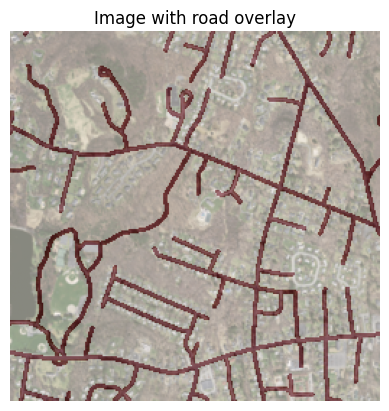

In [83]:
#display an image with mask overlay
img = images[1].permute(1, 2, 0).numpy() #CHW to HWC
mask = masks[1].squeeze().numpy() #CHW to HW

plt.imshow(img)
plt.imshow(mask, cmap='Reds', alpha=0.5)
plt.title("Image with road overlay")
plt.axis('off')
plt.show()

In [85]:
#define a convolution block

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3) #dropout 30%
        )

    def forward(self, x):
        return self.conv(x)

In [86]:
### MODEL ARCHITECTURE (U-NET) ###

class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        #encoder
        self.enc1 = ConvBlock(in_channels, 64)
        self.enc2 = ConvBlock(64, 128)
        self.enc3 = ConvBlock(128, 256)
        self.enc4 = ConvBlock(256, 512)
        self.pool = nn.MaxPool2d(2)

        #bottleneck
        self.bottleneck = ConvBlock(512, 1024)

        #decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = ConvBlock(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = ConvBlock(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = ConvBlock(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 =ConvBlock(128, 64)

        #output
        self.conv_final = nn.Conv2d(64, out_channels, kernel_size=1)
        
    def forward(self, x):

        #encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        #bottleneck
        b = self.bottleneck(self.pool(e4))

        #decoder with skip connections
        d4 = self.upconv4(b)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        #output
        out = self.conv_final(d1)

        return torch.sigmoid(out) #binary segmentation

In [87]:
#testing 
test_model = UNet(in_channels=3, out_channels=1)

x = torch.randn(1, 3, 256, 256)
y = test_model(x)

print(y.shape)

torch.Size([1, 1, 256, 256])


In [88]:
#define dice loss
def dice_loss(pred, target, smooth=1.):

    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = 1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth))

    return loss.mean()

In [89]:
#loss function as the combination of BCE and Dice loss

class BCEDiceLoss(nn.Module):

    def __init__(self, weight_dice=0.5):
        super().__init__()
        
        self.bce = nn.BCELoss()
        self.weight_dice = weight_dice

    def forward(self, pred, target):
        bce_loss = self.bce(pred, target)
        d_loss = dice_loss(pred, target)
        
        return bce_loss + self.weight_dice * d_loss

In [90]:
#training loop

def train_unet(model, train_loader, val_loader, epochs=10, lr=1e-3, device='cuda'):

    model = model.to(device)
    criterion = BCEDiceLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    print("Current device:" , device)

    best_val_loss = float('inf') #infinity

    #list to store losses
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            #compute loss
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        #validation
        model.eval()
        val_loss = 0

        with torch.no_grad():
            for images, masks in val_loader:

                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

        val_loss /=len(val_loader)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

        #save the best model
        if val_loss < best_val_loss:
            
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_road_seg_unet.pth")
            print("Best model saved")
    
    return train_losses, val_losses

In [91]:
#### WARNING: TRAINING EXECUTION PHASE COMPUTATIONALLY INTENSIVE ####

#create model
model = UNet(in_channels = 3,  out_channels = 1)

#train with recording losses
train_losses, val_losses = train_unet(model, train_loader, val_loader, epochs=10, lr=1e-3, device='cuda' if torch.cuda.is_available() else 'cpu')

Current device: cuda


Epoch 1/10: 100%|██████████| 290/290 [02:36<00:00,  1.86it/s]


Epoch 1: Train Loss = 0.6217, Val Loss = 0.4874
Best model saved


Epoch 2/10: 100%|██████████| 290/290 [02:19<00:00,  2.08it/s]


Epoch 2: Train Loss = 0.4615, Val Loss = 0.4317
Best model saved


Epoch 3/10: 100%|██████████| 290/290 [02:17<00:00,  2.11it/s]


Epoch 3: Train Loss = 0.4263, Val Loss = 0.3969
Best model saved


Epoch 4/10: 100%|██████████| 290/290 [02:16<00:00,  2.13it/s]


Epoch 4: Train Loss = 0.4131, Val Loss = 0.3426
Best model saved


Epoch 5/10: 100%|██████████| 290/290 [02:32<00:00,  1.90it/s]


Epoch 5: Train Loss = 0.3981, Val Loss = 0.3720


Epoch 6/10: 100%|██████████| 290/290 [02:24<00:00,  2.00it/s]


Epoch 6: Train Loss = 0.3890, Val Loss = 0.3380
Best model saved


Epoch 7/10: 100%|██████████| 290/290 [02:18<00:00,  2.09it/s]


Epoch 7: Train Loss = 0.3840, Val Loss = 0.3146
Best model saved


Epoch 8/10: 100%|██████████| 290/290 [02:18<00:00,  2.10it/s]


Epoch 8: Train Loss = 0.3770, Val Loss = 0.3643


Epoch 9/10: 100%|██████████| 290/290 [02:17<00:00,  2.11it/s]


Epoch 9: Train Loss = 0.3772, Val Loss = 0.3429


Epoch 10/10: 100%|██████████| 290/290 [02:18<00:00,  2.09it/s]


Epoch 10: Train Loss = 0.3695, Val Loss = 0.3316


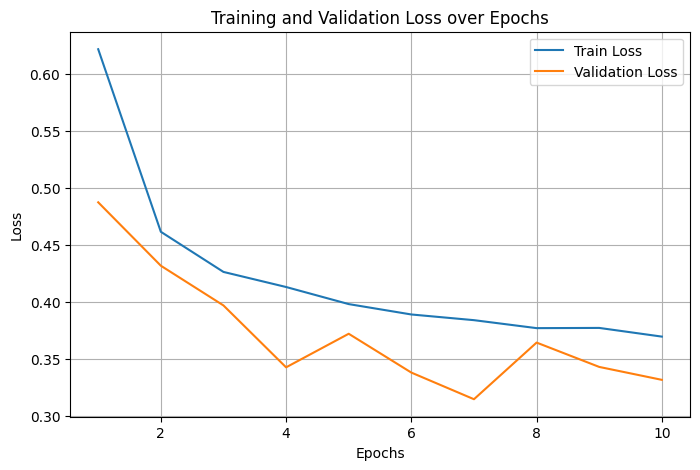

In [92]:
#plotting training and validation losses over time

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [93]:
#visualise prediction

def visualise_prediction(model, dataset, index, device='cuda'):

    model.eval()
    img, mask = dataset[index]
    img_tensor = img.unsqueeze(0).to(device) #add batch dimension

    with torch.no_grad():
        pred = model(img_tensor)[0,0].cpu().numpy()  #remove batch dimension and channel dimension

    plt.figure(figsize=(10,5))
    plt.subplot(1,3,1)
    plt.imshow(img.permute(1,2,0))
    plt.title("Satellite Image")
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(mask[0], cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(pred, cmap='gray') 
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.show()  

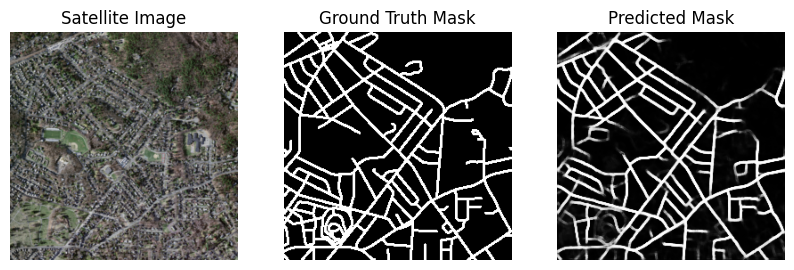

In [97]:
visualise_prediction(model, val_dataset, index=12)